# Analysis on the Viewer Numbers of Rocket Beans TV with Python

<img src="http://i.imgur.com/1qgG6gD.jpg" width="500" height="500" />

On January 15th 2015, the guys and gals from ~~Game One~~ [Rocket Beans](http://www.rocketbeans.de) started their 24/7 [Twitch-channel](http://www.twitch.tv/rocketbeanstv) - the first (and only?) German web TV channel of its kind. Now, after 20 month of non-stop streaming, they switch to their [Youtube-channel](https://www.youtube.com/user/ROCKETBEANSTV) for live-streaming - starting on 1st September 2016. 
This seems like a good time to pause and take a look at the viewer numbers of the channel via a little explorative data analysis. 

I use data provided by [skeb1](https://twitter.com/skceb1) who uses the Twitch API to upload viewer figures for every minute during the operation of the Twitch-channel: http://skceb.de/cron/stats.php **Thanks a lot for uploading!**

These numbers cannot tell us how many unique user visit the Twitch channel over a given period of time or how many additional views certain content receives on [Youtube](https://www.youtube.com/user/ROCKETBEANSTV). Nevertheless, they are a good indicator of how the channel was doing during that period (plus, I might get to analyzing their Twitter-Account or the Twitch-chat at a later time).

**Start by setting up the environment, reading in the data and bringing it into form:**

In [1]:
#Import modules:
import datetime as dt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#Enable inline plotting:
%matplotlib inline
#Set default figure size:
matplotlib.pylab.rcParams['figure.figsize'] = 10, 7.5

In [2]:
#Read in texfile:
openfile = open("D:\\RBTV\\RBTV_Twitch_Final_Zuschauerzahlen.csv")
rbtv_viewer = openfile.read()
openfile.close()

#Munge into form and convert to Pandas dataframe:
rbtv_viewerlist = rbtv_viewer.replace('\"','').split("\n")
rbtv_viewersplit = [i.split(",",1) for i in rbtv_viewerlist][1:-1]
df = pd.DataFrame(rbtv_viewersplit[1:],columns=["Date","Viewer"])
ts = df.set_index(pd.to_datetime(df["Date"], format="%d.%m.%Y %H:%M:%S"))
ts["Viewer"] = pd.to_numeric(ts["Viewer"])
ts.drop("Date", axis=1, inplace=True)

#Convert to evenly spaced time series and fill missing values with last observed value:
rbtv = ts.resample('1min', how='median').fillna(method='pad')

#Create variables for different time-parts:
rbtv["Time"]    = rbtv.index.time
rbtv['Hour']    = rbtv.index.hour
rbtv['Day']     = rbtv.index.day
rbtv['Weekday'] = rbtv.index.weekday
rbtv['Week']    = rbtv.index.weekofyear
rbtv['Month']   = rbtv.index.month
rbtv['Year']    = rbtv.index.year

#Twitch channel was shut down on 31.08.2016::23::59 so drop observations for September 2016:
rbtv = rbtv[rbtv.index.date<dt.date(2016,9,1)]

**Get a first glimse of the data:**

In [3]:
#Show first 5 observations of data:
rbtv.head()

,Viewer,Time,Hour,Day,Weekday,Week,Month,Year
Date,,,,,,,,
2015-01-15 18:37:00,757,18:37:00,18,15,3,3,1,2015
2015-01-15 18:38:00,757,18:38:00,18,15,3,3,1,2015
2015-01-15 18:39:00,10490,18:39:00,18,15,3,3,1,2015
2015-01-15 18:40:00,13232,18:40:00,18,15,3,3,1,2015
2015-01-15 18:41:00,13232,18:41:00,18,15,3,3,1,2015


In [4]:
#Show last 5 observations:
rbtv.tail()

,Viewer,Time,Hour,Day,Weekday,Week,Month,Year
Date,,,,,,,,
2016-08-31 23:55:00,16175,23:55:00,23,31,2,35,8,2016
2016-08-31 23:56:00,16399,23:56:00,23,31,2,35,8,2016
2016-08-31 23:57:00,16444,23:57:00,23,31,2,35,8,2016
2016-08-31 23:58:00,16602,23:58:00,23,31,2,35,8,2016
2016-08-31 23:59:00,16752,23:59:00,23,31,2,35,8,2016


In [5]:
#Format for better readability: no decimal numbers + thousands separators:
format = lambda x: "{:>,}".format(int(round(x)))
#Summary statistics of # of viewers:
rbtv["Viewer"].describe().apply(format)

count    855,683
mean       4,596
std        4,114
min            1
25%        1,729
50%        3,392
75%        5,970
max       67,176
Name: Viewer, dtype: object

The observations span from 15.01.2015 to 31.08.2016 encompassing more than 850,000 datapoints. The mean number of viewers in any given minute is about 4,600 while the median is almost 3,400. This suggests a right skewed distribution - i.e. a distribution that clusters among lower values but exhibits a long right tail with several very high values.

The maximum figure of 67,170 viewers seems too high - the viewer number reached a peak of about 50,000 on the very first day of broadcasting and never went much higher than 40,000 afterwards to the best of my knowledge. This suggests a technical issue which should be investigated. On a side note, the minimum seems too low as well as there are usually a couple of hundred streams turned on even in the middle of the night. However, especially at the beginning of the channel the server went down a couple of time so we should expect some sharp drops in the viewer numbers. As this happened quite a bit and actually represents real events, I will leave those values as they are. Let's concentrate on the potential outlier for now by looking at observations with more than 50,000 viewers:

In [6]:
#Return viewer numbers that are higher than 50,000:
rbtv[rbtv["Viewer"] >50000]["Viewer"].apply(format)

Date
2015-01-15 19:49:00    50,002
2015-01-15 19:50:00    50,002
2015-01-15 19:52:00    50,300
2015-01-15 19:53:00    50,395
2015-01-15 19:54:00    51,034
2015-01-15 19:55:00    51,945
2015-01-15 19:56:00    51,945
2015-01-15 19:57:00    51,945
2015-01-15 20:21:00    50,036
2015-01-15 20:22:00    50,036
2015-08-07 14:40:00    67,176
2015-08-07 14:41:00    67,176
Name: Viewer, dtype: object

As expected, most observations with 50,000 or more viewers occur on the very first day of the channel around 8 p.m. - a time when usually the highest number of people are watching at the same time.

In contrast, the maximum number of viewer, which is 15,000 higher than the next highest figure, occurs in the middle of the day on August 7th 2015. This looks suspiciously like a technical glitch so  let's investigate further by plotting the # of viewer for that particular day. 

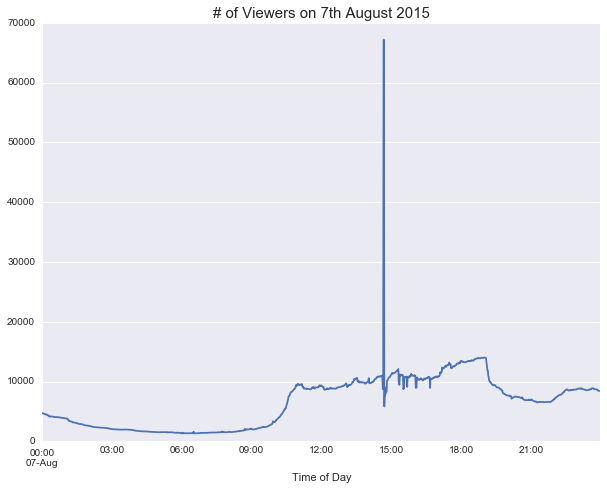

In [7]:
rbtv[rbtv.index.date == dt.date(2015,8,7)]["Viewer"].plot()
plt.title("# of Viewers on 7th August 2015", fontsize=15)
plt.xlabel("Time of Day")

This clearly looks like a technical problem so let's replace the outliers with the last observed value and plot again to make sure that the data looks reasonable:

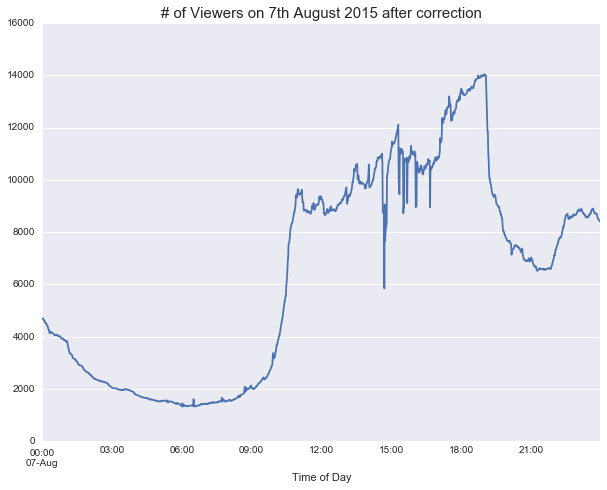

In [8]:
#Replace Values:
matplotlib.pylab.rcParams['figure.figsize'] = 10, 7.5
rbtv["Viewer"].replace(67176,rbtv[rbtv.index == "2015-08-07 14:39:00"]["Viewer"][0], inplace=True)
#Plot again:
rbtv[rbtv.index.date == dt.date(2015,8,7)]["Viewer"].plot()
plt.title("# of Viewers on 7th August 2015 after correction", fontsize=15)
plt.xlabel("Time of Day")

**Time-Series Plots:**

Now we can look at all of the data by plotting the entire time series along with a 30-day exponentially weighted moving average:

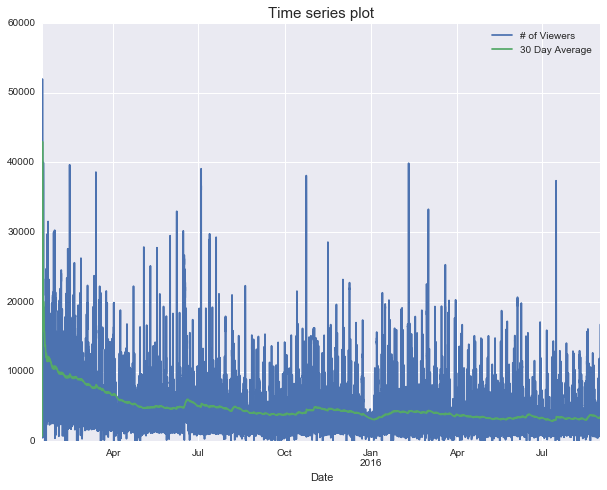

In [9]:
#Plot time series:
rbtv["Viewer"].plot(label='# of Viewers')
#Smooth over one month: 60 minutes a 24 hours a 30 days:)
pd.ewma(rbtv["Viewer"], span=60*24*30).plot(label='30 Day Average')
#Format:
plt.xlabel("Date")
plt.title("Time series plot", fontsize=15)
plt.legend()

It appears that the average viewers number declined relatively fast at first but then remained relatively stable. However, the number of events with more than 20,000 viewers (usually due to special live events such as the Pen&Paper series) seems to have declined somewhat after August 2015.

Another way to look at the time series is to **decompose** it into a trend, a seasonal component that accounts for regular pattern over time (for instance weekly pattern) and a residual value that captures irregular deviations from the regular pattern such as exceptionally high viewer numbers during Pen&Paper episodes:

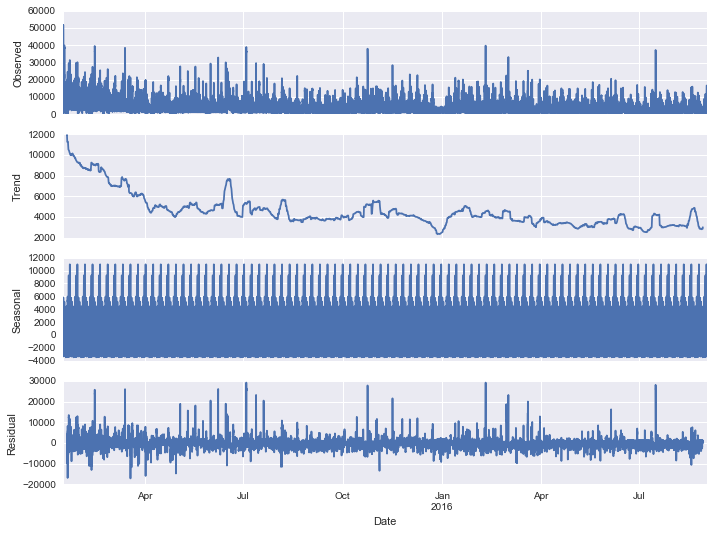

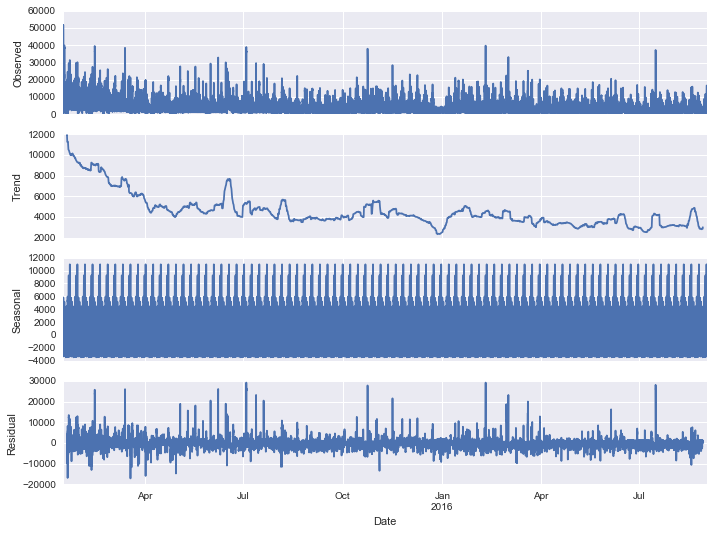

In [10]:
#Use modified version of statsmodels seasonal_decompose function to avoid problems with the frequency:
%run D:\RBTV\seasonal_decomp.py
res = seasonal_decompose(rbtv.Viewer, freq=60*24*7)
res.plot()

The plot above makes it quite clear that the trend (or base rate) stayed steadily around 4,000 viewers from April/May 2015 on. The number of exceptionally high deviation from that usual base of viewers, as given by the residual, has somewhat declined over time. One does see a very pronounced weekly pattern in the time series - we will come back to this later.



Another way to highlight underlying regularities in the data (as well as exceptional cases) is to overlay the time series for each week. To make the common pattern more visible, I use an exponentially weighted 1-hour moving average to smooth out jaggs in the data.

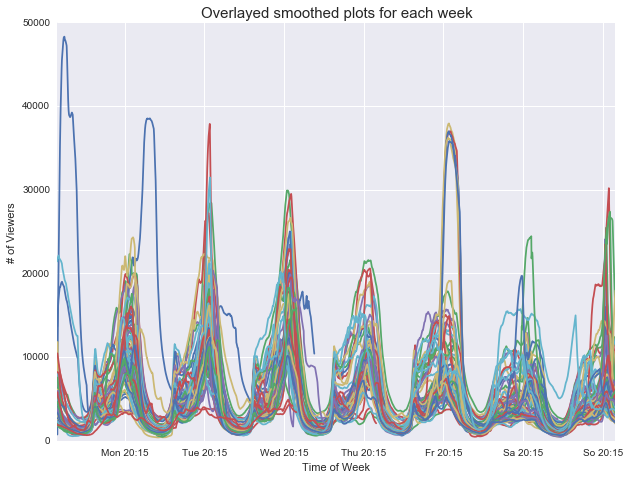

In [11]:
#Plotting:
for year in range(2015,2017):
    for week in range(1,54):
        try:
            pd.ewma(rbtv[(rbtv.index.week == week) 
                       & (rbtv.index.year == year)].groupby(["Weekday", "Time"])["Viewer"].mean(), 
                    span=60).plot()
        except:
            continue
            
#List for x-ticks and labels:
ticks = [20*60 +15 + 24*60*i for i in range(7)]
labels ="Mon Tue Wed Thu Fr Sa So".split()
labels = [day + " 20:15" for day in labels]

#Formating:
plt.xticks(ticks)
plt.xlabel("Time of Week")
plt.ylabel("# of Viewers")
plt.gca().set_xticklabels(labels)
plt.title("Overlayed smoothed plots for each week", fontsize=15)

The common pattern here is that viewer number peek around 20:15 each day even though that peek is differently pronounced for each weekday. Wednesday is coming out fairly strong in this respect - probably due to the flagship-show *"Bohn Jour"*. We can also observe some days which defy this pattern with much higher viewer numbers.

**Common Viewing Pattern:**


Looking at average daily viewer numbers is yet another way to get a better feeling for the typical viewer patterns:

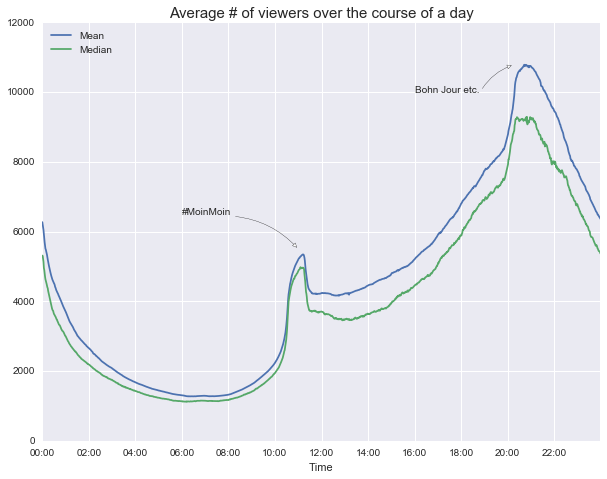

In [12]:
#Plot series:
rbtv.groupby("Time")["Viewer"].mean().plot(label="Mean")
rbtv.groupby("Time")["Viewer"].median().plot(label="Median")
#Put text in plot:
plt.annotate('#MoinMoin', xy=("11:00", 5500), xytext=("06:00", 6500),  
             arrowprops = dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", relpos=(1., 0.), fc="w"))
plt.annotate('Bohn Jour etc.', xy=("20:15", rbtv.groupby("Time")["Viewer"].mean().max()), xytext=("16:00", 10000),  
             arrowprops = dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", relpos=(1., 0.), fc="w"))
#X-axis, legend and title:
hours = '00:00 02:00 04:00 06:00 08:00 10:00 12:00 14:00 16:00 18:00 20:00 22:00'.split()
plt.xticks(hours)
plt.gca().set_xticklabels(hours)
plt.legend(loc=2)
plt.title("Average # of viewers over the course of a day", fontsize=15)

Unsurprisingly the mean lies constantly over the median number of viewers. The spread between mean and median is the highest between 8 p.m. and 10 p.m. when the most popular formats such as the weekly late night show *Bohn Jour* can be expected to pull the mean up. 

Generally we see a spike at around 11 a.m. when (most likely) the daily morning show *MoinMoin* attracts an average audience  of more than 5,000. Afterwards the number of viewers climbs steadily over the course of the day until 8 p.m. when we see another spike to about 11,000 mean viewers during the evening program. Afterwards the viewer numbers peter out and finally level off at below 2,00 between 2 a.m. and 10 a.m.

Another way to go about this is to look at how **spread out the distribution of viewers** is over the course the day. To this end we can plot the quartiles (25%-quantile, median and 75%-quantile) of the number of viewers:

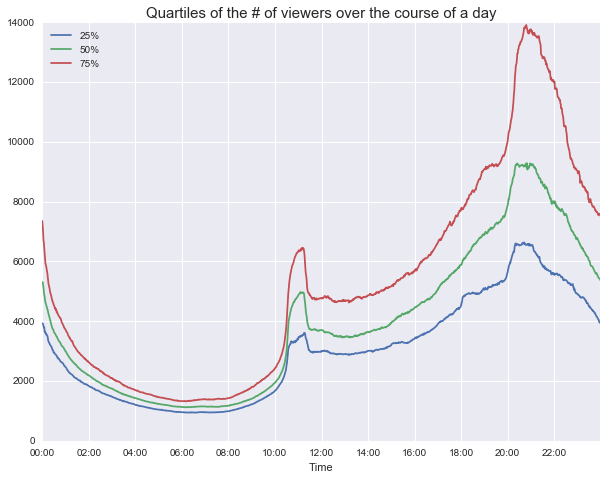

In [13]:
#Plot:
rbtv.groupby('Time')['Viewer'].describe().unstack()[["25%", "50%","75%"]].plot()
#Format:
plt.legend(loc=2)
plt.xticks(hours)
plt.gca().set_xticklabels(hours)
plt.title("Quartiles of the # of viewers over the course of a day", fontsize=15)

The variation in the data tends to go hand in hand with the amount of viewers. During the night and early morning the viewer number is not only very low but also does not vary much. On the other hand, we see huge variations in the number of viewers during prime time (8 p.m. to 10 p.m.): while the median figure is about 9,000 during that time, the 75%-quantile is up to 14,000. In contrast, the 25%-quantile of prime time viewers is even below the 75%-quantile during the *MoinMoin* broadcast.

We can combine our findings regarding the common patterns during a day and over the course of a week to get a more complete picture. Thus, let's look at the average number of viewers during the course of a day **differentiated by weekday**:

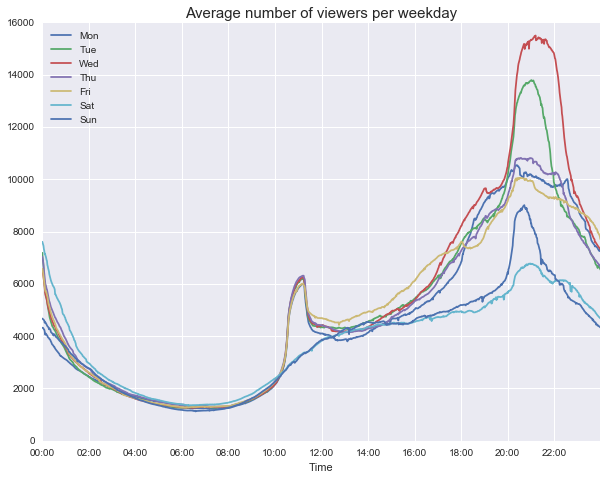

In [14]:
hours = '00:00 02:00 04:00 06:00 08:00 10:00 12:00 14:00 16:00 18:00 20:00 22:00'.split()
weekdays = 'Mon Tue Wed Thu Fri Sat Sun'.split()
fig = plt.figure()
for week in range(7):
    rbtv[rbtv.index.weekday == week].groupby("Time")["Viewer"].mean().plot(label=weekdays[week])

plt.legend(loc=2)
plt.xticks(hours)
plt.gca().set_xticklabels(hours)
plt.title("Average number of viewers per weekday", fontsize=15)

We find that the spike around 11 a.m. is indeed very likely due to *MoinMoin* as it only occurs during weekdays. As seen before, the peak between 8 p.m. and 10 p.m. is most pronounced on Wednesdays - the time of the week when *Bohn Jour* airs. Saturdays and Sundays exhibit the lowest viewer figures on average.

We can condense the differences between days of the week by looking at descriptive statistics for each day (here 0 stands for Mondays and 6 for Sundays):

In [15]:
#By weekday:
rbtv.groupby('Weekday')['Viewer'].describe().apply(format).unstack()

,count,mean,std,min,25%,50%,75%,max
Weekday,,,,,,,,
0,"122,400","4,659","3,908",2,"1,587","3,448","6,638","26,694"
1,"122,400","4,935","4,255",1,"1,679","3,820","6,780","39,876"
2,"122,400","5,352","4,822",1,"1,710","3,630","7,256","31,526"
3,"121,283","4,806","4,088",14,"1,824","3,652","6,612","51,945"
4,"122,400","4,863","4,859",1,"1,755","3,724","6,039","39,977"
5,"122,400","3,796","3,012",5,"1,865","2,958","4,673","34,536"
6,"122,400","3,763","3,206",2,"1,692","3,078","4,678","32,987"


Interestingly, eventhough Wednesdays(2) feature the highest average number of viewers (as well as the highest 75%-quartile), its median is very similar to the rest of the working week.  

To make the core summary statistics for each day easier to grasp, we can visualize them via a **Boxplot**. Here the quartiles  are depicted as a box while extreme values (outliers) are drawn as points above a so-called whisker.

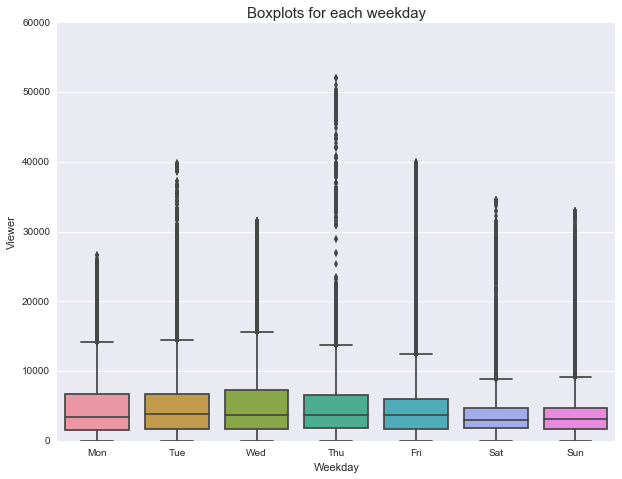

In [16]:
#Plot:
sns.boxplot(x="Weekday", y="Viewer", data=rbtv)
#Formating:
plt.gca().set_xticklabels('Mon Tue Wed Thu Fri Sat Sun'.split())
plt.title("Boxplots for each weekday", fontsize=15)

From the boxplots we can see that while Wednesdays tends to see the most viewers, other weekdays experience much higher viewernumbers. Thursdays extreme outliers are due to the fact that the launch of the channel happend to be a thursday. The high number and magnitude of extreme values on Fridays is due to the fact that oftentimes special events will be aired on that day.

**Development over time revisited:**

If we are interested in the development of the viewer number over time, it makes sense to **aggregate the data by month**. This gives us a more concise picture compared to the time-series plots above. In addition, we can look at other moments of the distribution than just the mean. First, let's take a look at monthly summary statistics:

In [17]:
#Descriptive statistics by month:
rbtv.groupby(['Year','Month'])['Viewer'].describe().apply(format).unstack()

count    mean    std  min    25%    50%     75%     max
Year Month                                                          
2015 1      23,363  10,619  7,691   14  4,514  9,015  14,268  51,945
     2      40,320   8,542  5,579    2  3,615  7,951  11,572  39,654
     3      44,640   6,696  4,936   16  2,617  5,883   8,994  38,606
     4      43,200   4,806  3,315    2  2,021  4,278   6,286  22,251
     5      44,640   4,770  3,394  191  1,951  4,381   6,102  29,492
     6      43,200   5,369  4,262  192  2,057  4,551   6,934  32,987
     7      44,640   4,780  4,274  355  1,738  4,063   6,357  39,085
     8      44,640   4,117  3,246    5  1,564  3,420   5,447  22,317
     9      43,200   3,858  2,628  114  1,556  3,427   5,268  15,370
     10     44,640   4,552  4,302   14  1,537  3,438   5,815  38,106
     11     43,200   4,435  3,483    1  1,729  3,543   5,920  28,566
     12     44,640   3,453  2,796    2  1,431  2,972   4,136  23,206
2016 1      44,640   4,220  3,234    2  1,611  3,467   5,655  21,309
     2      41,760   4,292  3,812    3  1,590  3,373   5,451  39,876
     3      44,640   3,760  3,524    1  1,454  2,900   4,674  33,277
     4      43,200   3,373  2,564   14  1,364  2,711   4,459  16,732
     5      44,640   3,203  2,639    2  1,227  2,527   4,229  18,748
     6      43,200   3,559  2,988    3  1,440  2,655   4,489  20,672
     7      44,640   3,166  3,476   71  1,220  2,384   3,540  37,372
     8      44,640   3,513  2,874    1  1,338  2,645   4,513  16,752

As seen in the time-series above, this table shows us that the initial viewing numbers declined rapidly until April 2015 and from then on continued in a much more gentle downward slope. We can better visualize this development for different parts of the distribution by plotting the quartiles per month in a line plot or via a boxplot for each month:

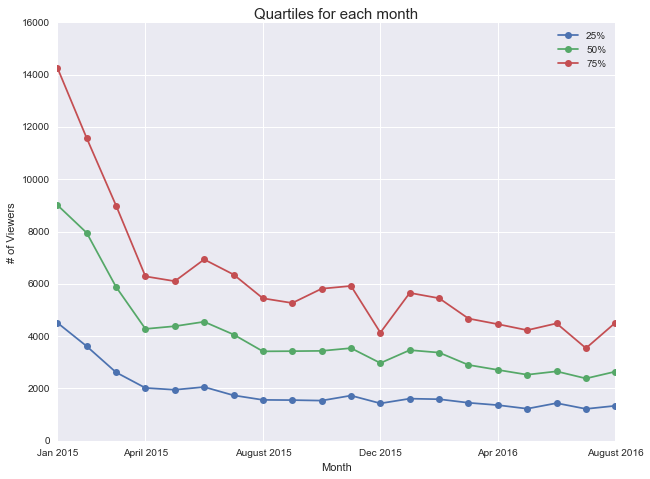

In [18]:
#Plot:
rbtv.groupby(['Year','Month'])['Viewer'].describe().unstack()[["25%", "50%","75%"]].plot(marker='o')
#Formating:
plt.xlabel("Month")
plt.ylabel("# of Viewers")
plt.xticks([0,3,7,11,15,19])
plt.gca().set_xticklabels(["Jan 2015", "April 2015", "August 2015", "Dec 2015",
                           "Apr 2016", "August 2016"])
plt.title("Quartiles for each month", fontsize=15)

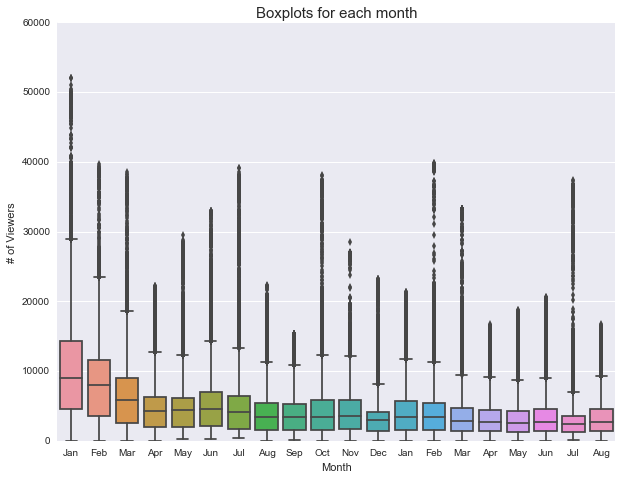

In [19]:
#Boxplot:
rbtv['YearMonth'] = rbtv["Year"]*100 + rbtv["Month"]
sns.boxplot(x="YearMonth", y="Viewer", data=rbtv)
#Formating:
plt.xlabel("Month")
plt.ylabel("# of Viewers")
plt.gca().set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", 
                           "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"])

plt.title("Boxplots for each month", fontsize=15)

To differentiate this view some more, we can plot these summary statistics **by calender week** instead of month. 

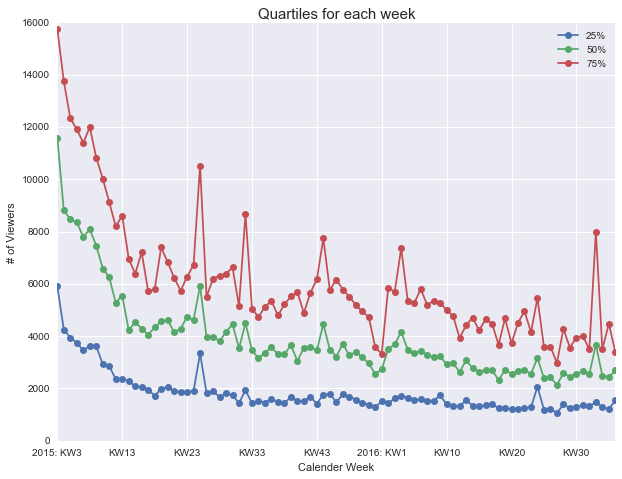

In [20]:
#Plot:
rbtv.groupby(['Year','Week'])['Viewer'].describe().unstack()[["25%", "50%","75%"]].plot(marker='o')
#Formating:
plt.xlabel("Calender Week")
plt.ylabel("# of Viewers")
plt.gca().set_xticklabels(["2015: KW3", "KW13", "KW23", "KW33", "KW43", 
                           "2016: KW1", "KW10", "KW20", "KW30"])
plt.title("Quartiles for each week", fontsize=15)

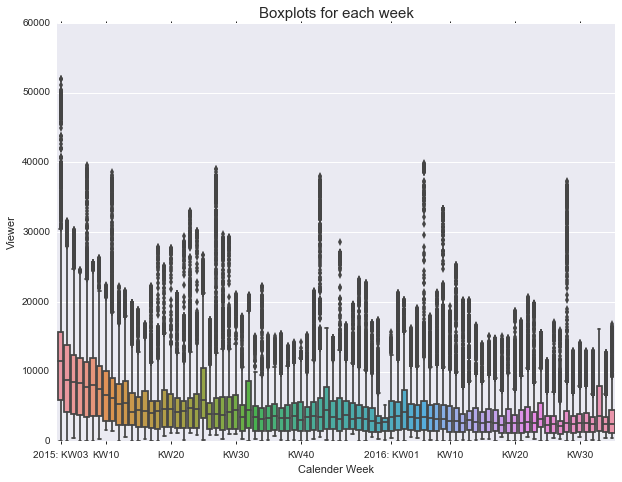

In [21]:
#Preparation:
rbtv["YearWeek"] = rbtv["Year"]*100 + rbtv["Week"]
rbtv["YearWeek"].replace(201653,201553, inplace=True)
sns.set_style("darkgrid",{'xtick.major.size': 2.5}) 
#Boxplot:
sns.boxplot(x="YearWeek", y="Viewer", data=rbtv)
#Formating:
plt.xlabel("Calender Week")
ticks = [0, 7, 17, 27, 37, 51, 60, 70, 80]
plt.xticks(ticks)
plt.gca().set_xticklabels(["2015: KW03", "KW10", "KW20", "KW30", "KW40", "2016: KW01", "KW10", "KW20", "KW30"])
plt.title("Boxplots for each week", fontsize=15)
sns.set_style({'xtick.major.size': 0.0}) 

Looking at viewer numbers by week makes it easier to spot deviations from the overall pattern. The upward shift in calendar week 25 in 2015, for instance, is due to a general increase in the number of viewers (but not in extreme viewer numbers as shown by the outliers) during the E3 due to RBTV's live reporting. On the other hand, in weeks which feature more or higher outlier values but no increase in the general level of viewers (such as calendar week 28 in 2016) there usually occurred some one-time special event such as a new *B.E.A.R.D.S.* episode. One conspicuous feature of the graph is the lack of extremely high viewing numbers right at the end of 2015. The reason for this was a vacation close-down in which no live-shows were aired. Instead, only pre-produced content was shown.

**Distributional Analysis:**

Finally, it is insightful to look at the datapoints **without paying attention to the time dimension**. The best way to do so is to look at a **histogram** of the data:

(0, 55000)

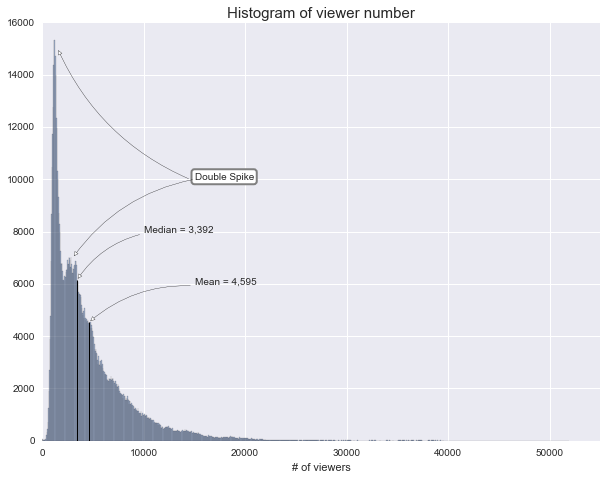

In [22]:
#Plot Histogram:
sns.distplot(rbtv["Viewer"], bins=1000, kde=False)

#Preparation to return height of bin for plotting:
hist, bins = np.histogram(rbtv["Viewer"], bins=1000)
center = (bins[:-1] + bins[1:]) / 2
def return_position(number, mylist):
    return min(range(len(mylist)), key=lambda i: abs(mylist[i]-number))

#Annotate mean:
plt.vlines(x=rbtv["Viewer"].mean(), ymin=0, ymax=hist[return_position(rbtv["Viewer"].mean(),center)], linewidths=1)
plt.annotate('Mean = ' + str('{0:,}'.format(int(rbtv["Viewer"].mean()))), 
             xy=(rbtv["Viewer"].mean(), hist[return_position(rbtv["Viewer"].mean(),center)]), xytext=(15000, 6000),  
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", relpos=(0, 0.), fc="w"))
#Annotate median:
plt.vlines(x=rbtv["Viewer"].median(), ymin=0, ymax=hist[return_position(rbtv["Viewer"].median(),center)], linewidths=1)
plt.annotate('Median = ' + str('{0:,}'.format(int(rbtv["Viewer"].median()))), 
             xy=(rbtv["Viewer"].median(), hist[return_position(rbtv["Viewer"].median(),center)]), xytext=(10000, 8000),  
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", relpos=(0, 0.), fc="w"))

#Annotate double mode:
plt.annotate('Double Spike', xy=(1500, 15000), xytext=(15000, 10000),  
             arrowprops = dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", relpos=(0, 0.), fc="w"),
             bbox=dict(boxstyle="round", fc="w", ec="gray", lw=2))
plt.annotate('', xy=(3000, 7000), xytext=(15000, 10000),  
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", relpos=(0, 0.), fc="w"))

#Title/Lable/Formating:
plt.title("Histogram of viewer number", fontsize=15)
plt.xlabel("# of viewers")
plt.xlim(0,55000)

As expected we find a very **right-skewed distribution**, i.e. a distribution where the majority of the observations feature low viewer numbers while there are a few observations with very large values (**long right tail**). Moreover the distribution is **bimodal**, meaning it features two spikes (though the second is not as pronounced) as highlighted in the graph. From what we have seen so far, it stands to reason that the larger spike close to zero is due to the constantly low number of viewers during the night. Thus, it makes sense to **split the data** along this line (10 a.m. to 2 a.m. vs. 2 a.m. to 10 a.m.) and plot a separate histogram for each group:

(0, 55000)

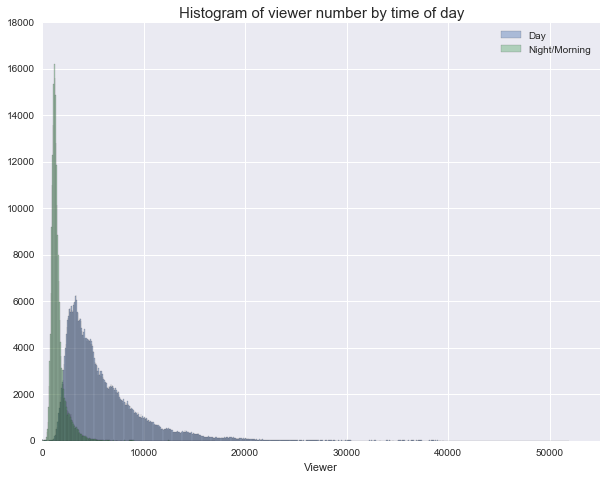

In [23]:
#Split data:
day = rbtv[(rbtv["Hour"]<2) | (rbtv["Hour"]>=10)]['Viewer']
night = rbtv[(rbtv["Hour"]>2) & (rbtv["Hour"]<10)]['Viewer']
#Plot histogram for each group (adjust # of bins to group size):
sns.distplot(day, kde=False, bins = 1000, label= "Day") 
sns.distplot(night, kde=False, bins = 300, label= "Night/Morning")
#Format:
plt.legend()
plt.title("Histogram of viewer number by time of day", fontsize=15)
plt.xlim(0,55000)

The graph shows that the two distributions can be split with little overlap - which supports the presumptions that the two peaks in the former graph are due to different viewing pattern during the night. The distribution of the viewer numbers during the night/morning (from 2 a.m. till 10 a.m.) is concentrated around a very narrow region (50% of the distribution lies between 1,200 and 1,900 viewers). Due to this low level of variation in the number of viewers during the night, it makes sense to **focus on the distributon during the day instead**. Thus, we plot only the viewer numbers from 10 a.m. to 2.a.m. and restrict the graph to 25,000 viewers to get a closer look at the majority of the distribution around lower levels of viewers:

(0, 25000)

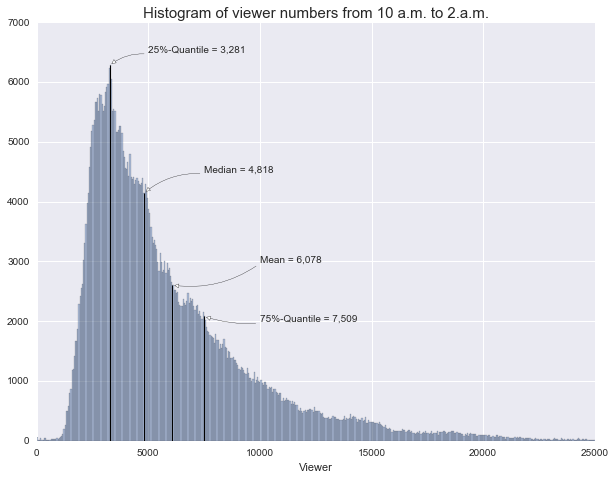

In [24]:
day = rbtv[(rbtv["Hour"]<2) | (rbtv["Hour"]>=10)]['Viewer']
sns.distplot(day, kde=False, bins = 1000) 

hist, bins = np.histogram(day, bins=1000)
center = (bins[:-1] + bins[1:]) / 2

#Annotate mean:
plt.vlines(x=day.mean(), ymin=0, ymax=hist[return_position(day.mean(),center)], linewidths=1)
plt.annotate('Mean = ' + str('{0:,}'.format(int(day.mean()))), 
             xy=(day.mean(), hist[return_position(day.mean(),center)]), xytext=(10000, 3000),  
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", relpos=(0, 0), fc="w"))
#Annotate median:
plt.vlines(x=day.median(), ymin=0, ymax=hist[return_position(day.median(),center)], linewidths=1)
plt.annotate('Median = ' + str('{0:,}'.format(int(day.median()))), 
             xy=(day.median(), hist[return_position(day.median(),center)]), xytext=(7500, 4500),  
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", relpos=(0, 0), fc="w"))

#Annotate 25%-Quantile:
plt.vlines(x=day.quantile(.25), ymin=0, ymax=hist[return_position(day.quantile(.25),center)], linewidths=1)
plt.annotate('25%-Quantile = ' + str('{0:,}'.format(int(day.quantile(.25)))), 
             xy=(day.quantile(.25), hist[return_position(day.quantile(.25),center)]), xytext=(5000, 6500),  
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", relpos=(0, 0), fc="w"))

#Annotate 75%-Quantile:
plt.vlines(x=day.quantile(.75), ymin=0, ymax=hist[return_position(day.quantile(.75),center)], linewidths=1)
plt.annotate('75%-Quantile = ' + str('{0:,}'.format(int(day.quantile(.75)))), 
             xy=(day.quantile(.75), hist[return_position(day.quantile(.75),center)]), xytext=(10000, 2000),  
             arrowprops =dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.1", relpos=(0, 0),fc="w"))

plt.title("Histogram of viewer numbers from 10 a.m. to 2.a.m.", fontsize=15)
plt.xlim(0,25000)

Unsurprisingly, the summary statistics are higher during this time of the day compared to the whole day (mean: 6,000 vs. 4,600; median: 4800 vs. 3,400). About 50% of the time during the day, we see viewer numbers between 3,300 and 7,500.

For the future, it would be interesting to associate the viewer numbers with certain shows and take the figures for the Youtube repository into account, among other. 